# Analyze A/B Test Results to Determine the Conversion Rate of a New Web Page

#### Table of Contents
- Introduction
- Part I - Probability
- Part II - A/B Test
- Part III - Regression
- Conclusion

### Introduction

In this project, I will analyze the results of an A/B test conducted by an e-commerce website. The objective is to determine whether the company should adopt the new page, retain the existing one, or extend the experiment for a more informed decision.

### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df = pd.read_csv('../Data/ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# The number of rows in the dataset
df.shape

(294478, 5)

In [4]:
# The number of unique users in the dataset
df.user_id.nunique()

290584

In [5]:
# The proportion of users converted (Overall).
df['converted'].mean()

0.11965919355605512

In [6]:
# The proportion of users converted (by treatment group).
temp = df[(df['group']=='control') & (df['landing_page']=='old_page') | (df['group']=='treatment') & (df['landing_page']=='new_page')]
temp.groupby('group').converted.mean()

group
control      0.120386
treatment    0.118807
Name: converted, dtype: float64

In [7]:
#The number of times the new_page and treatment don't match.
df_control = df.query('group == "control"')
df_treat = df.query('group == "treatment"')
df_control_wrong = df_control.query('landing_page == "new_page"')
df_treat_wrong = df_treat.query('landing_page == "old_page"')
df_control_wrong.shape[0] + df_treat_wrong.shape[0]

3893

In [8]:
# Do any of the rows have missing values?
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
# Drop rows with the wrong values 
df2 = df.drop(df_control_wrong.index)
df2.drop(df_treat_wrong.index, inplace = True)

# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
# How many unique user_ids are in df2?
df2.user_id.nunique()

290584

In [11]:
df2.shape[0]

290585

There is one duplicate user_id in df2. Check what's the user_id and remove it.

In [12]:
#Find dups and put into a df in case we need in future
dup_df = df2[df2.user_id.duplicated(keep = False)]
dup_df

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
#Drop duplicates on user id, removing inplace from df
df2.drop_duplicates(subset = "user_id", inplace = True)

In [14]:
#Confirm our user id still exists but only once
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [15]:
# Calculate the probability of converting conditional on an individual being in the control group.
control_conv = df2.query('group == "control"').converted.mean()
# Calculate the probability of converting conditional on an individual being in the treatment group.
treat_conv = df2.query('group == "treatment"').converted.mean()
# Calculate the probability of converting condition regardless of the page they receive.
conv = df2.converted.mean()
# print the results
print(f"Probability of converting conditional on an individual being in the control group: {control_conv}")
print(f"Probability of converting conditional on an individual being in the treatment group: {treat_conv}")
print(f"Probability of converting condition regardless of the page they receive: {conv}")


Probability of converting conditional on an individual being in the control group: 0.1203863045004612
Probability of converting conditional on an individual being in the treatment group: 0.11880806551510564
Probability of converting condition regardless of the page they receive: 0.11959708724499628


In [16]:
# What is the probability that an individual received the new page?
p_new_page = df2[df2['landing_page'] == 'new_page'].user_id.count()\
/df2.user_id.count()
p_new_page

0.5000619442226688

`Observations`

- If we look at these descriptive statistics results, the split of those who are in the control group and the treatment group is about 50%, giving an equal representation of each.

- The conversion rate for the control group is around 12%, while for treatment group is just around 11.88%.

- This would lead us to believe that there is no significant impact of using the new page on the treatment group, since conversion rate is not significantly positivly affected.

### Part II - A/B Test

Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

- Define our Hypothesis

    - $H_0$: p_new - p_old <= 0(or p_control = p_treatment)

    - $H_1$: p_new - p_old > 0 (or p_control != p_treatment)

- Calculate the test statistic


#### Approach A: A walkthrough simulation with detailed steps

Assume under the null hypothesis, p_new and p_old both have "true" success rates equal to the converted success rate regardless of page - that is p_new and p_old are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page. 

Use a sample size for each page equal to the ones in ab_data.csv.

Perform the sampling distribution for the difference in proportions between p_new and p_old over 10,000 iterations to get the distribution under the null hypothesis.

In [17]:
# Get the converted rate regardless of the page
p_new = df2.converted.mean()
# Get the converted rate regardless of the page and store it as pnew_h0 
p_old = df2.converted.mean()

# Get the number of individuals in the treatment group
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
# count the number of users who recieved the old_page
n_old = df2[df2['landing_page'] != 'new_page'].shape[0]

Simulate $n_{new}$ transactions with their corresponding conversion rates $p_{new}$ and $n_{old}$ transactions with their corresponding conversion rate $p_{old}$.


In [18]:
# Get sample choice between [0,1]
# with sample size equal to number of users in df
# given probability 
new_page_converted = np.random.choice([0,1], size = n_new, p=[1-p_new,p_new])

In [19]:
# Get sample choice between [0,1]
# with sample size equal to number of users in df
# given probability 
old_page_converted = np.random.choice([0,1], size = n_old,replace=True, p=[1-p_old,p_old])

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process process above. Storeall 10,000 values in a numpy array called p_diffs.

In [20]:
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.choice([0,1], size = n_new, replace=True, p=[1-p_new,p_new])
    old_page_converted = np.random.choice([0,1], size = n_old, replace=True, p=[1-p_old, p_old])
    p_diff = new_page_converted.mean()- old_page_converted.mean()
    p_diffs.append(p_diff)

p_diffs[:10]

[0.0010510361466867235,
 -0.0002637207953676002,
 0.0016979102373652494,
 0.0002936979174150839,
 0.001911581493905537,
 -0.0013992446663406571,
 -0.0004355979342326177,
 -2.0369719948148957e-06,
 -0.0006147883710163199,
 0.0017183937435165109]

In [21]:
p_diffs = np.asarray(p_diffs)

In [22]:
actual_diff = treat_conv - control_conv

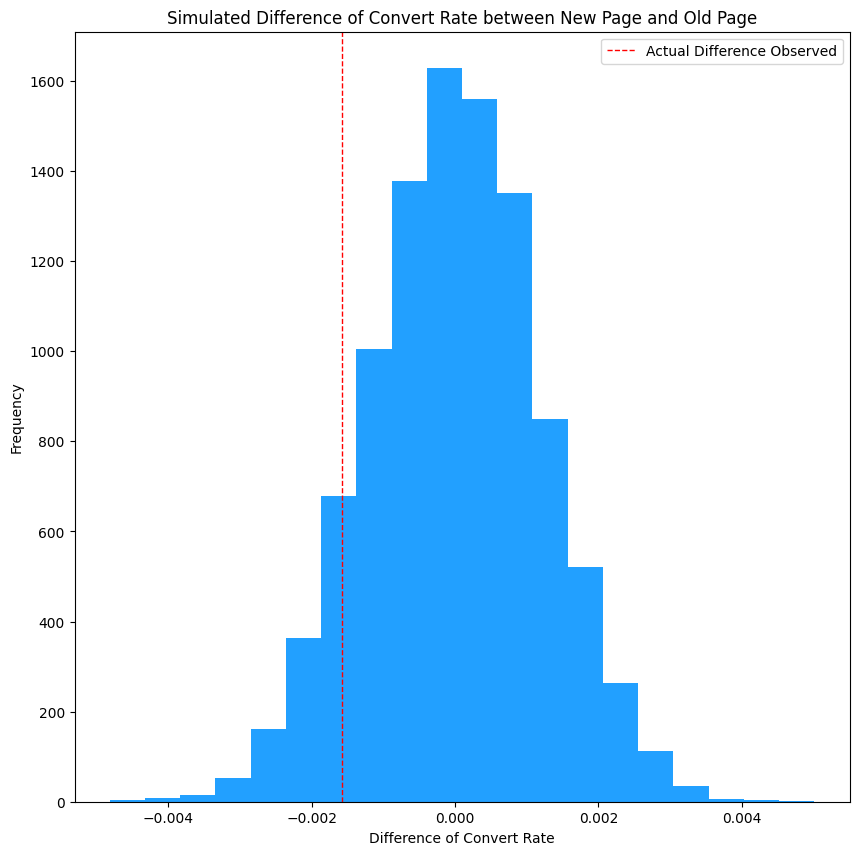

In [23]:
# plot histogram of the p_diffs
plt.subplots(figsize=(10, 10))
plt.hist(p_diffs, color='#22a0ff', bins=20)
plt.xlabel('Difference of Convert Rate')
plt.ylabel('Frequency')
plt.title('Simulated Difference of Convert Rate between New Page and Old Page')
# plot the line of actual difference
plt.axvline(actual_diff , c='red', linestyle='dashed', linewidth=1, label="Actual Difference Observed")
plt.legend()
plt.show()

What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?

This proportion is the p-value.

In [24]:
(p_diffs > actual_diff).mean()

0.9028


Observations

- We have calculated something called the P-Value. The P-Value is the probability of observing our chosen statistic (or one more extreme in favour of the alternative) if the Null hypothesis is true. The smaller the P-Value, the stronger the evidence against the null hypothesis and in favour of the alternative hypothesis.

- Typically we would expect the P-Value to be lower than the level of α (typically 0.05). The α indicates the percentage chance of committing a Type I error if the null is true.

- We have calculated our P-Value to be 0.9 which is large. This tells us that a high proportion (90%) of the converted differences in the Null hypothesis distribution are larger than the actual difference observed. This effectively tells us that there is a high probability conversion rate will be larger under null hypothesis.

- Therefore, given the P-Value 0.9, as such, we fail to reject the null and conclude that there is insufficient evidence that there is a difference between the groups.





#### Approach B: Built-in Python Code
We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [25]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').converted.count()
convert_new = df2.query('landing_page == "new_page" & converted == 1').converted.count()

In [26]:

z_score, p_value = sm.stats.proportions_ztest \
([convert_new, convert_old], [n_new, n_old], alternative='larger')
print('z-score: ',z_score ,', p-value: ', p_value)

z-score:  -1.3109241984234394 , p-value:  0.9050583127590245


Observations

The calculated values align with those obtained during the bootstrapped hypothesis testing.

### Part III - A regression approach

In this final part, we will see that the results achieved in the A/B test in Part II above can also be achieved by performing regression.


Since each row is either a conversion or no conversion,We will be performing logistic regression.

`Logistic Regression`

The goal is to use statsmodels to fit the regression model specified to see if there is a significant difference in conversion based on which page a customer receives. However, first we need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.

In [27]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [28]:
df2['ab_page'] = df2['landing_page'].map({'new_page': 1, 'old_page': 0})
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


Use statsmodels to instantiate the regression model on the two columns created, then fit the model using the two columns created to predict whether or not an individual converts.

In [29]:
log_m = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_m.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [30]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Mar 2025   Pseudo R-squ.:               8.077e-06
Time:                        14:38:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

`P-Value`

- The P-Value stated here as a result of the logistic regression is 0.190.

- This value is above an α level of 0.05, but it is difference since we have performed a two tailed test.

- We fail to reject the null in this situation.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. Read in the countries.csv dataset and merge together the two datasets on the appropriate rows. 

In [31]:
countries_df = pd.read_csv('../Data/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [32]:
# Find unique values of Country
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [33]:
# Add dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
# Convert boolean True/False to 1/0 for dummy variables
df_new[['CA', 'UK', 'US']] = df_new[['CA', 'UK', 'US']].astype(int)
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [34]:
# Fit our new model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 23 Mar 2025   Pseudo R-squ.:               1.521e-05
Time:                        14:40:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""


The P-Values for each country is above a 0.05 α level. 

Therefore, we fail to reject the null and conclude that on it's own, there is no significant impact from country in the conversion rates for the two pages.

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. We will create the necessary additional columns, and fit the new model.


In [35]:
# Adding an Interaction Variable between page and country 
# to see if there significant effects on conversion

df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


`Observations and Conclusion`

Observations After utilising some interaction variables in the logistic regression model, there continues to be no variable with significant p-values. With that, we fail to reject the null hypothesis. There is insufficient evidence to suggest that there is an interaction between country and page that will predict whether a user converts.

After our data analysis, based on the information available to us, we do not have sufficient evidence to suggest that the new page will result in more conversions than the old page.

In [36]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 23 Mar 2025   Pseudo R-squ.:               3.482e-05
Time:                        14:41:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""